In [4]:
import numpy as np
import os
import torch
from misc.example_helper import *
import importlib
import processing
import models
%load_ext autoreload
%autoreload 2
importlib.reload(processing)
importlib.reload(models)
from processing.data_manager import SHREDDataManager
from processing.parametric_data_manager import ParametricSHREDDataManager
from models.shred_models import SHRED
from models.shred_models import evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    compression = 50,
    time=np.arange(0, 2000),
    method="all"
)


# # Add data to manager (no sensors)
input_folder = "data14fields_npz"
for filename in os.listdir(input_folder):
    if filename.endswith(".npz") and (filename == 'ne_3D.npz' or filename == 'EfX_3D.npz'):
        file_path = os.path.join(input_folder, filename)
        manager.add_field(
            data=file_path,
            id = str(os.path.splitext(filename)[0]),
            random_sensors=3,
        )
        print(f"Processed: {filename}")

# Add data to manager (with sensors)
filename = 'ni_3D.npz'
file_path = os.path.join(input_folder, filename)
ni_3D = np.load(file_path)
ni_3D = ni_3D[ni_3D.files[0]]
mobile_sensors = [
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=True),
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=False)
]
manager.add_field(
    data=ni_3D,
    # random_sensors=3,
    # stationary_sensors=[(7, 9), (0,0)],
    # mobile_sensors=mobile_sensors,
    id = str(os.path.splitext(filename)[0])
)


Processed: ne_3D.npz
Processed: EfX_3D.npz


In [104]:
manager.input_summary

field id sensor id                     sensor type location/trajectory
0    ne_3D   ne_3D-0  stationary (randomly selected)          (238, 213)
1    ne_3D   ne_3D-1  stationary (randomly selected)           (164, 70)
2    ne_3D   ne_3D-2  stationary (randomly selected)          (145, 122)
3   EfX_3D  EfX_3D-0  stationary (randomly selected)           (64, 148)
4   EfX_3D  EfX_3D-1  stationary (randomly selected)           (12, 122)
5   EfX_3D  EfX_3D-2  stationary (randomly selected)           (184, 84)

In [105]:
manager.sensor_measurements

time       ne_3D-0       ne_3D-1       ne_3D-2   EfX_3D-0  EfX_3D-1  \
0        0  5.445000e+16  4.806700e+16  4.903000e+16    214.760    185.25   
1        1  4.990300e+16  5.007300e+16  5.087000e+16     87.781   -628.67   
2        2  4.980600e+16  5.128900e+16  5.221300e+16   -538.300  -1328.50   
3        3  5.006500e+16  5.223500e+16  5.322700e+16  -1068.600  -2622.40   
4        4  5.007500e+16  5.435500e+16  5.505700e+16  -1224.500  -4091.90   
...    ...           ...           ...           ...        ...       ...   
1995  1995  5.049800e+16  1.327400e+17  1.359300e+17 -11565.000 -37271.00   
1996  1996  5.098700e+16  1.285500e+17  1.335600e+17 -13255.000 -34605.00   
1997  1997  5.158300e+16  1.254000e+17  1.325500e+17 -15254.000 -31757.00   
1998  1998  5.242200e+16  1.247400e+17  1.327400e+17 -14083.000 -32086.00   
1999  1999  5.393500e+16  1.259500e+17  1.346200e+17  -9971.200 -30725.00   

      EfX_3D-2  
0       124.00  
1     -1315.90  
2     -1539.30  
3     -1168.20  
4      -632.02  
...        ...  
1995   4088.90  
1996   3575.00  
1997   3349.00  
1998   2356.00  
1999   2243.40  

[2000 rows x 7 columns]

In [106]:
# Get train/val/test datasets
train_set, val_set, test_set = manager.preprocess()

# Print dataset shapes
print('Data Shapes:')
print ('Reconstructor Data')
print('train X:', train_set.reconstructor_dataset.X.shape)
print('train Y:', train_set.reconstructor_dataset.Y.shape)
print('val X:', val_set.reconstructor_dataset.X.shape)
print('val Y:', val_set.reconstructor_dataset.Y.shape)
print('test X:', test_set.reconstructor_dataset.X.shape)
print('test Y:', test_set.reconstructor_dataset.Y.shape)

print ('Predictor Data')
print('train X:', train_set.predictor_dataset.X.shape)
print('train Y:', train_set.predictor_dataset.Y.shape)
print('val X:', val_set.predictor_dataset.X.shape)
print('val Y:', val_set.predictor_dataset.Y.shape)
print('test X:', test_set.predictor_dataset.X.shape)
print('test Y:', test_set.predictor_dataset.Y.shape)

print ('Sensor Forecaster Data')
print('train X:', train_set.sensor_forecaster_dataset.X.shape)
print('train Y:', train_set.sensor_forecaster_dataset.Y.shape)
print('val X:', val_set.sensor_forecaster_dataset.X.shape)
print('val Y:', val_set.sensor_forecaster_dataset.Y.shape)
print('test X:', test_set.sensor_forecaster_dataset.X.shape)
print('test Y:', test_set.sensor_forecaster_dataset.Y.shape)

Data Shapes:
Reconstructor Data
train X: torch.Size([1600, 21, 6])
train Y: torch.Size([1600, 150])
val X: torch.Size([200, 21, 6])
val Y: torch.Size([200, 150])
test X: torch.Size([200, 21, 6])
test Y: torch.Size([200, 150])
Predictor Data
train X: torch.Size([1600, 21, 6])
train Y: torch.Size([1600, 150])
val X: torch.Size([200, 21, 6])
val Y: torch.Size([200, 150])
test X: torch.Size([200, 21, 6])
test Y: torch.Size([200, 150])
Sensor Forecaster Data
train X: torch.Size([1600, 21, 6])
train Y: torch.Size([1600, 6])
val X: torch.Size([200, 21, 6])
val Y: torch.Size([200, 6])
test X: torch.Size([200, 21, 6])
test Y: torch.Size([200, 6])


In [107]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
val_errors = shred.fit(train_set, val_set, num_epochs=500, patience=100, verbose=True)


Fitting Reconstructor...


Epoch 1/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 2/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 3/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 4/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 5/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 6/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 7/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 8/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 9/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 10/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 11/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 12/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 13/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 14/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 15/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 16/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 17/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 18/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 19/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 20/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 21/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 22/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 23/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 24/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 25/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 26/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 27/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 28/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 29/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 30/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 31/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 32/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 33/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 34/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 35/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 36/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 37/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 38/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 39/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 40/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 41/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 42/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 43/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 44/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 45/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 46/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 47/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 48/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 49/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 50/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 51/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 52/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 53/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 54/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 55/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 56/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 57/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 58/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 59/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 60/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 61/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 62/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 63/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 64/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 65/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 66/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 67/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 68/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 69/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 70/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 71/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 72/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 73/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 74/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 75/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 76/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 77/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 78/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 79/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 80/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 81/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 82/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 83/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 84/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 85/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 86/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 87/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 88/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 89/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 90/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 91/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 92/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 93/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 94/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 95/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 96/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 97/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 98/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 99/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 100/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 101/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 102/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 103/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 104/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 105/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 106/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 107/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 108/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 109/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 110/500:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 111/500:   0%|          | 0/25 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [25]:
evaluate(shred = shred, test_dataset=test_set, data_manager=manager, uncompress=True)

ne_3D    EfX_3D     ni_3D
reconstruction   0.047172  0.093189  0.091021
prediction       0.094711  0.139944  0.152657
forecast         0.093287  0.139169  0.150565
sensor_forecast  0.055437       NaN       NaN

In [26]:
reconstruction = shred.reconstruct(test_set.reconstructor_dataset.X).detach().cpu().numpy()

In [27]:
reconstruction.shape

(200, 197376)

In [35]:
reconstruction = shred.reconstruct(test_set.reconstructor_dataset.X).detach().cpu().numpy()
dataset_dict_recon = manager.postprocess(reconstruction, uncompress = True, method = 'reconstructor')
true_dataset_dict_recon = manager.postprocess(test_set.predictor_dataset.Y.cpu().numpy(),  uncompress = True, method = 'reconstructor')

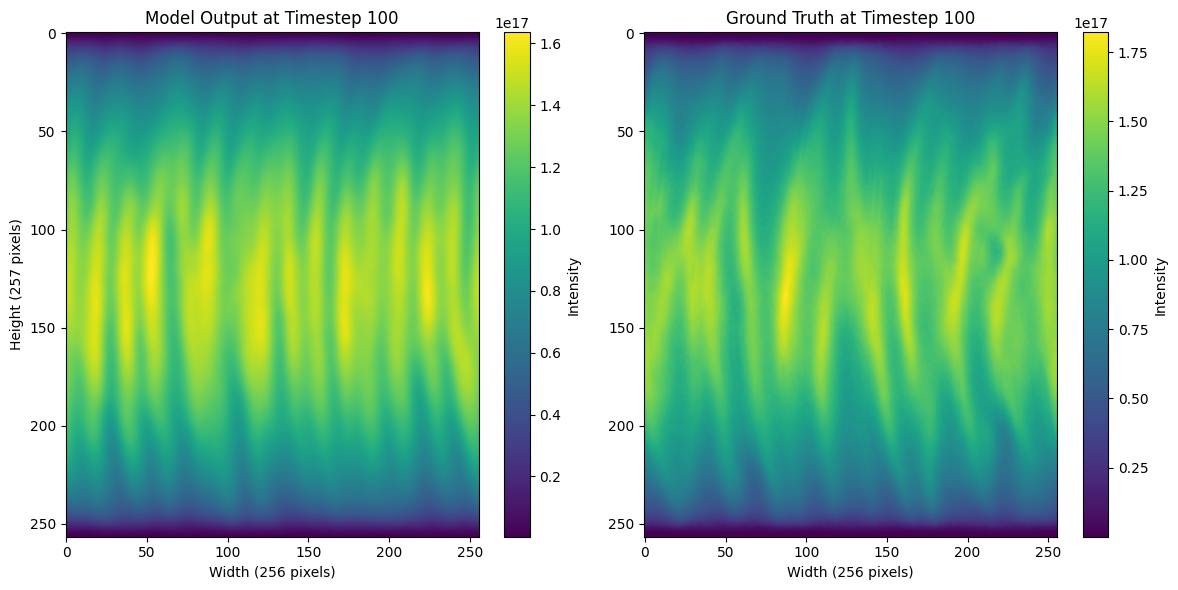

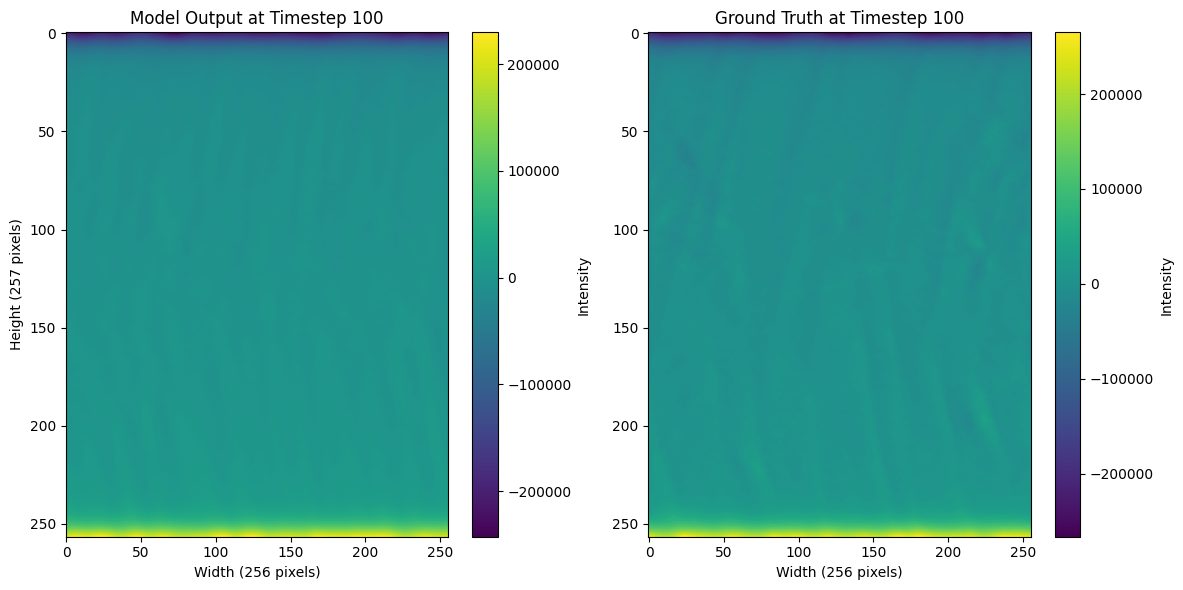

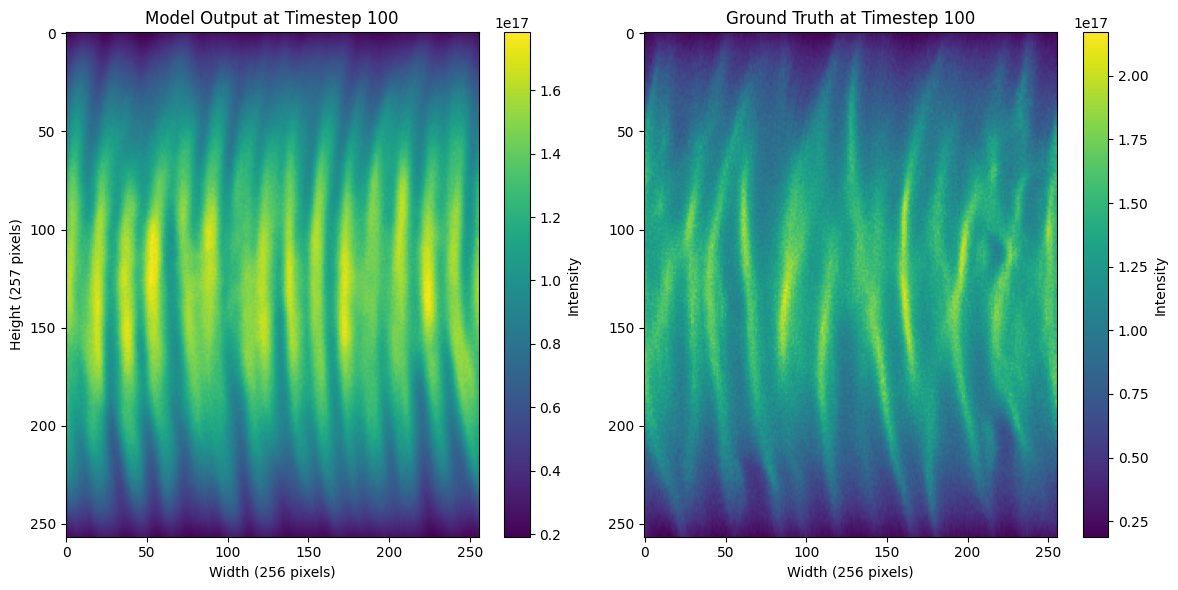

In [36]:
t = 100
for key in dataset_dict_recon.keys():
    plot_frame_comparison(dataset_dict_recon[key], true_dataset_dict_recon[key], timestep=t)  # Plot frame at timestep 100

In [34]:
prediction = shred.predict(test_set.predictor_dataset.X).detach().cpu().numpy()
dataset_dict_prediction = manager.postprocess(prediction, method = 'predictor')
true_dataset_dict_prediction = manager.postprocess(test_set.predictor_dataset.Y.cpu().numpy(), method = 'predictor')

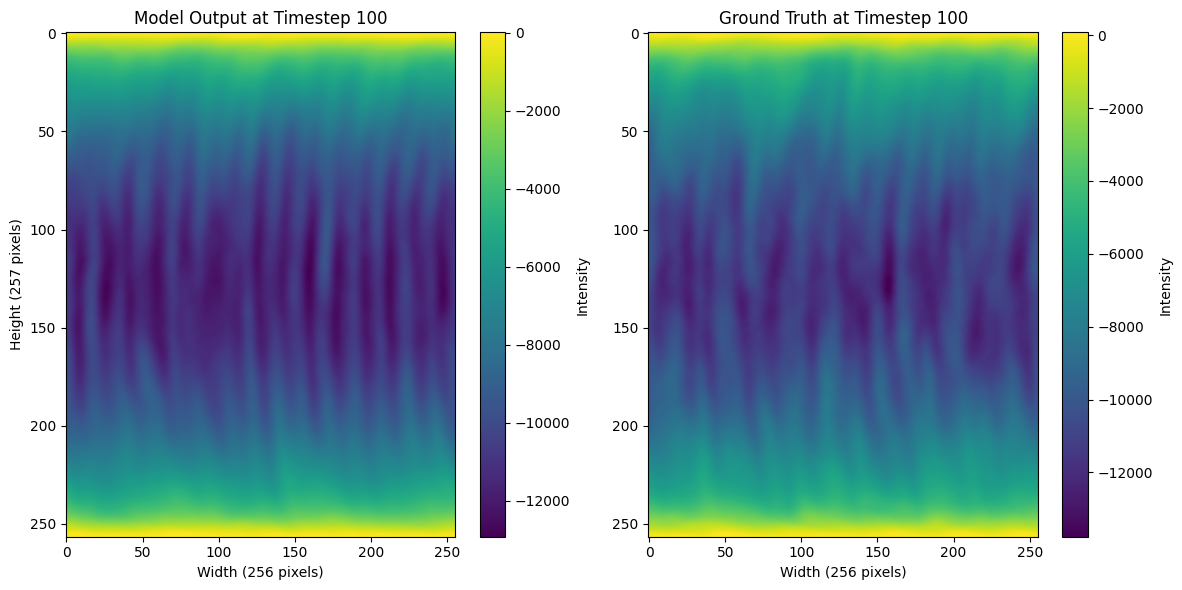

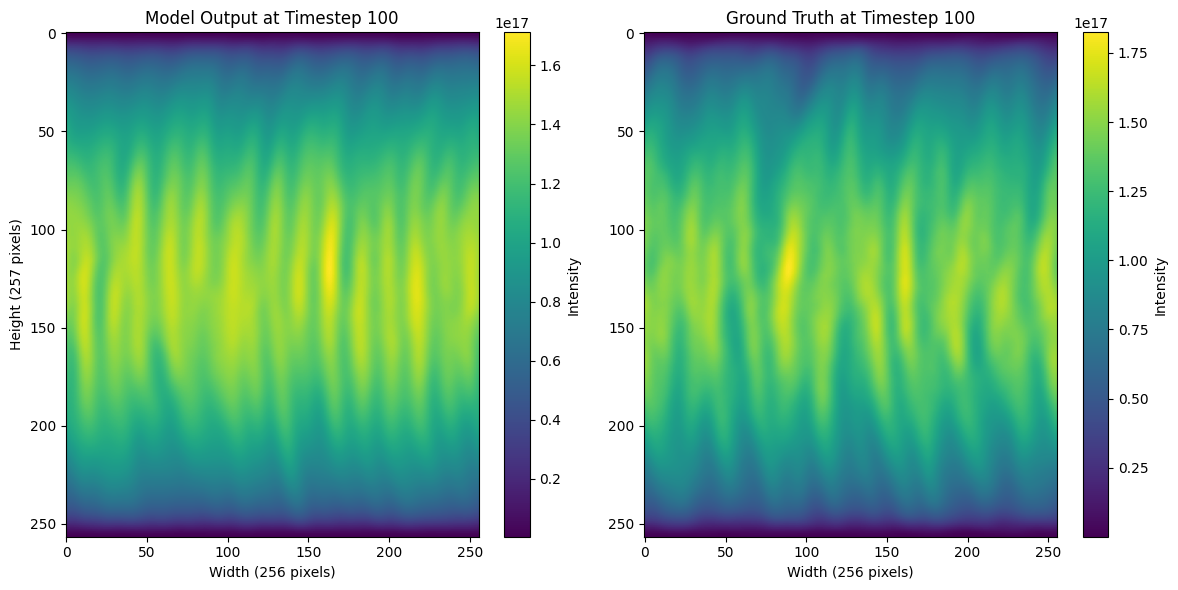

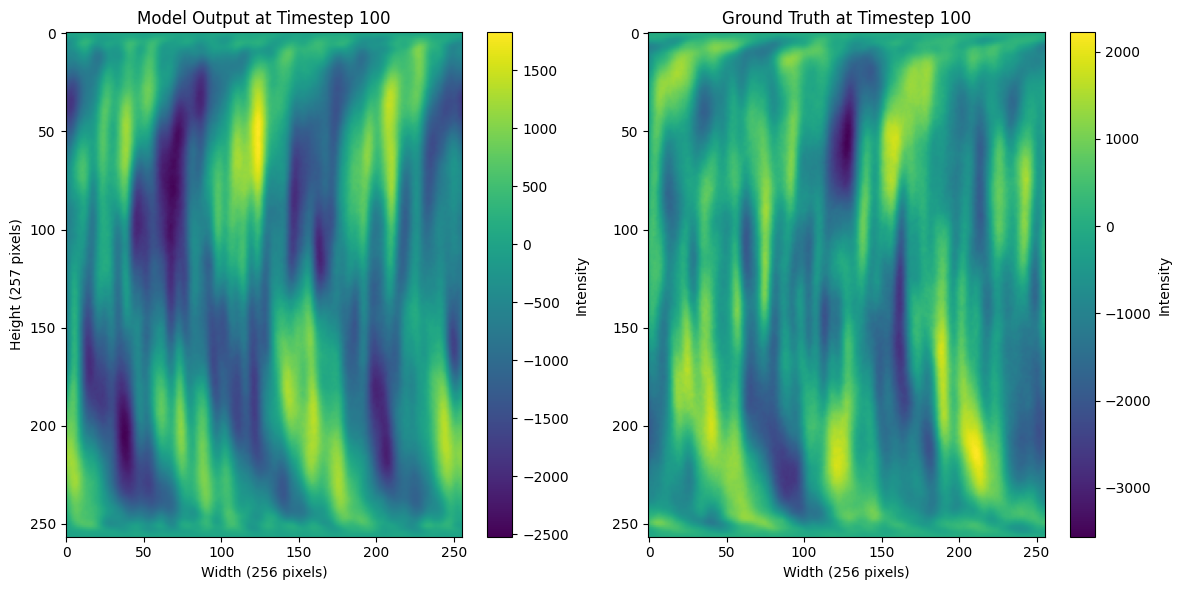

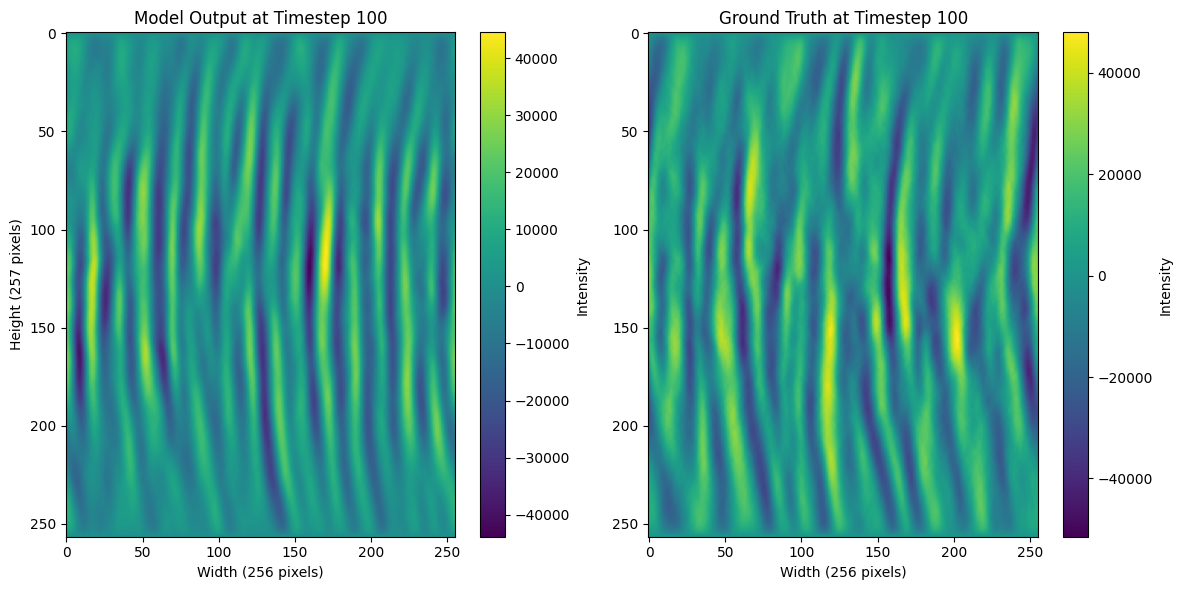

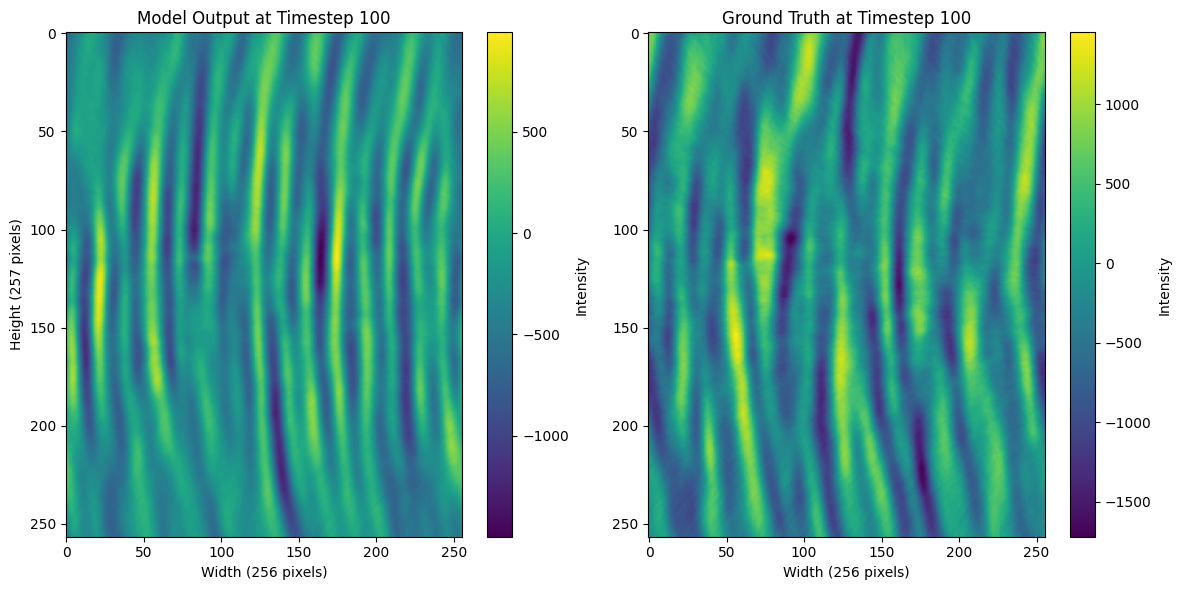

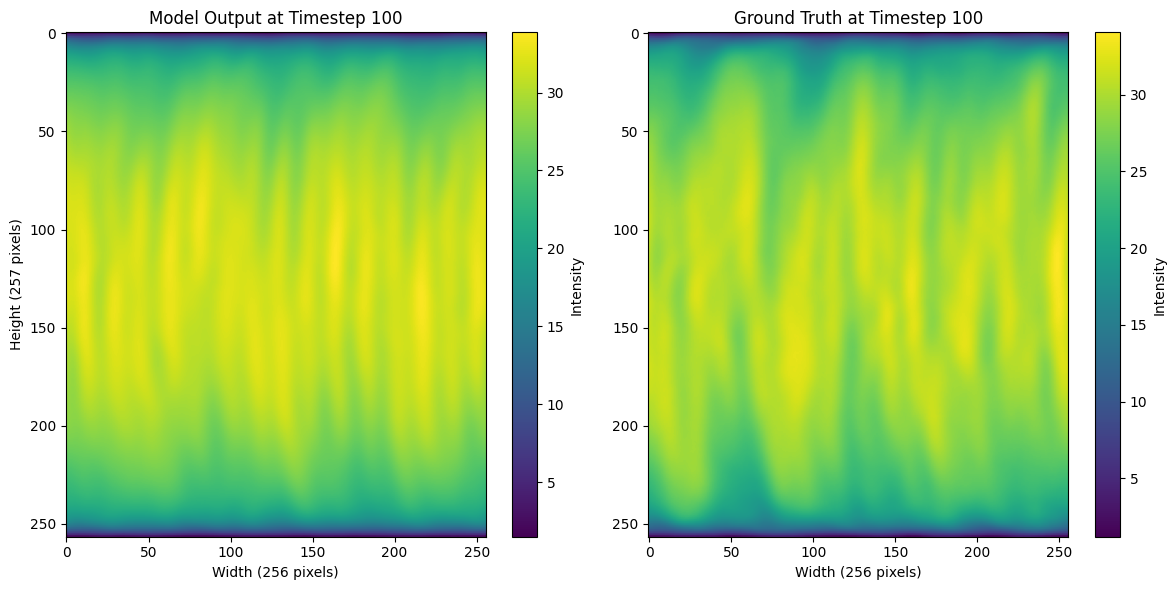

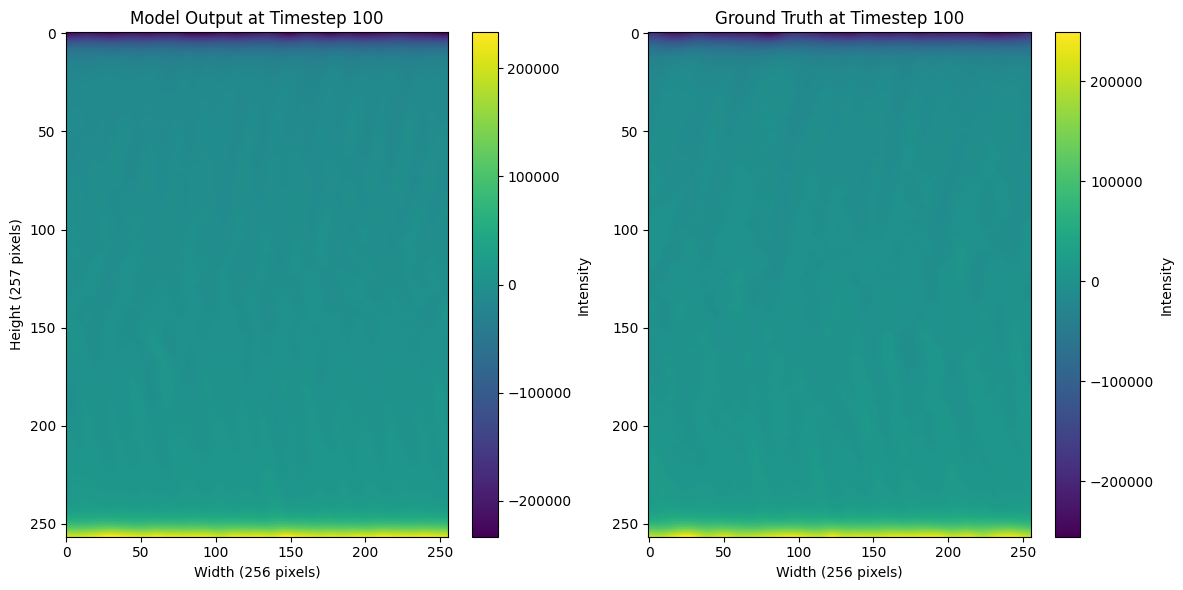

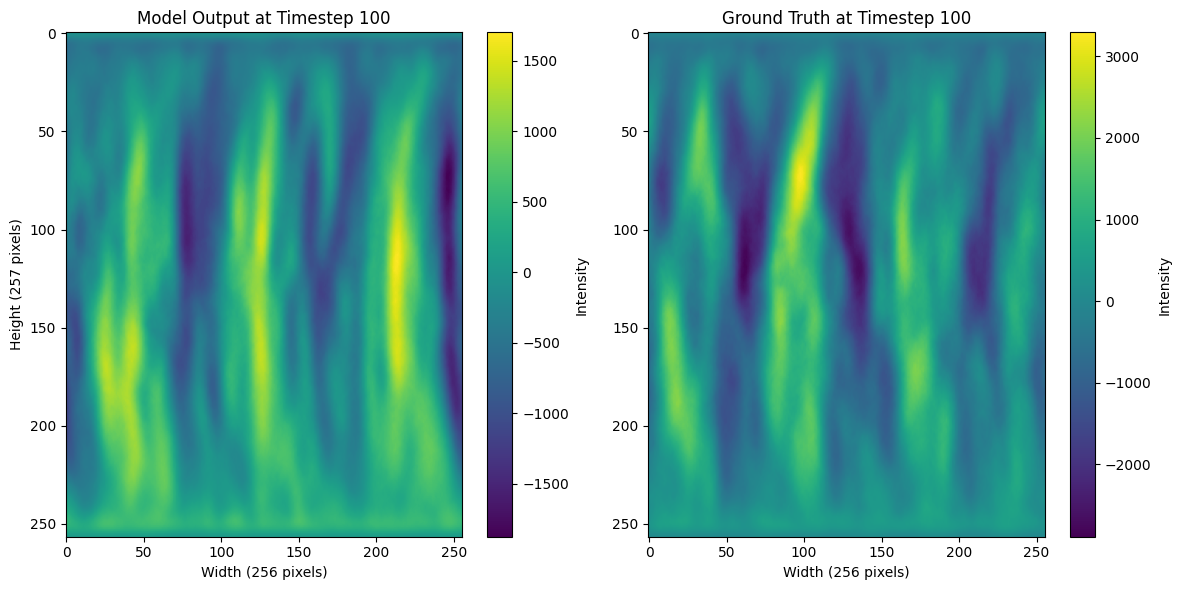

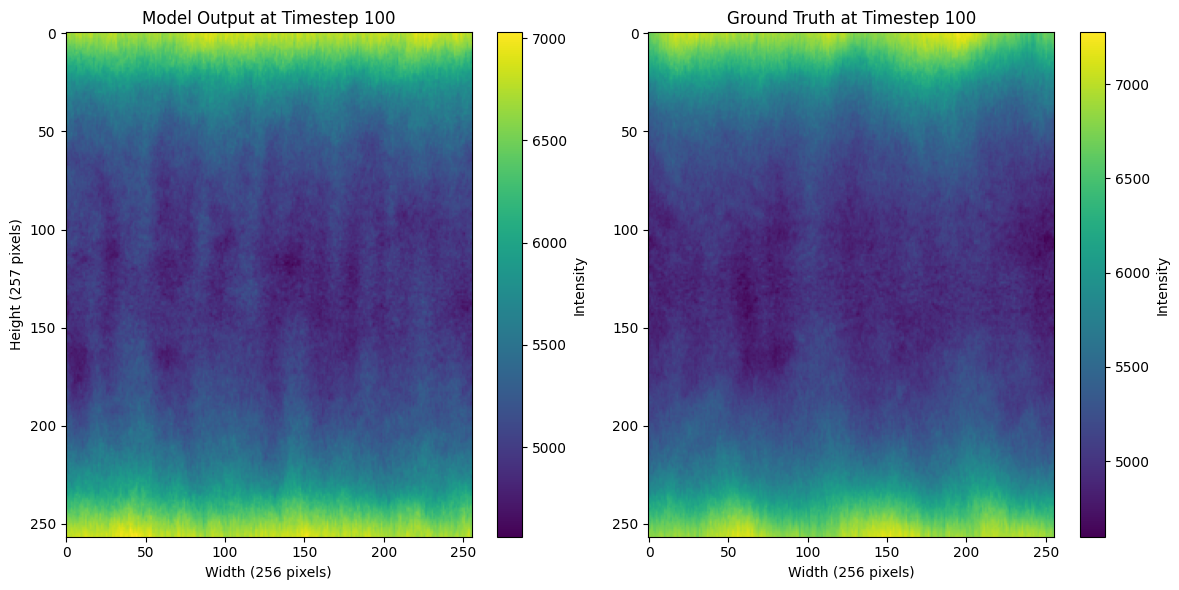

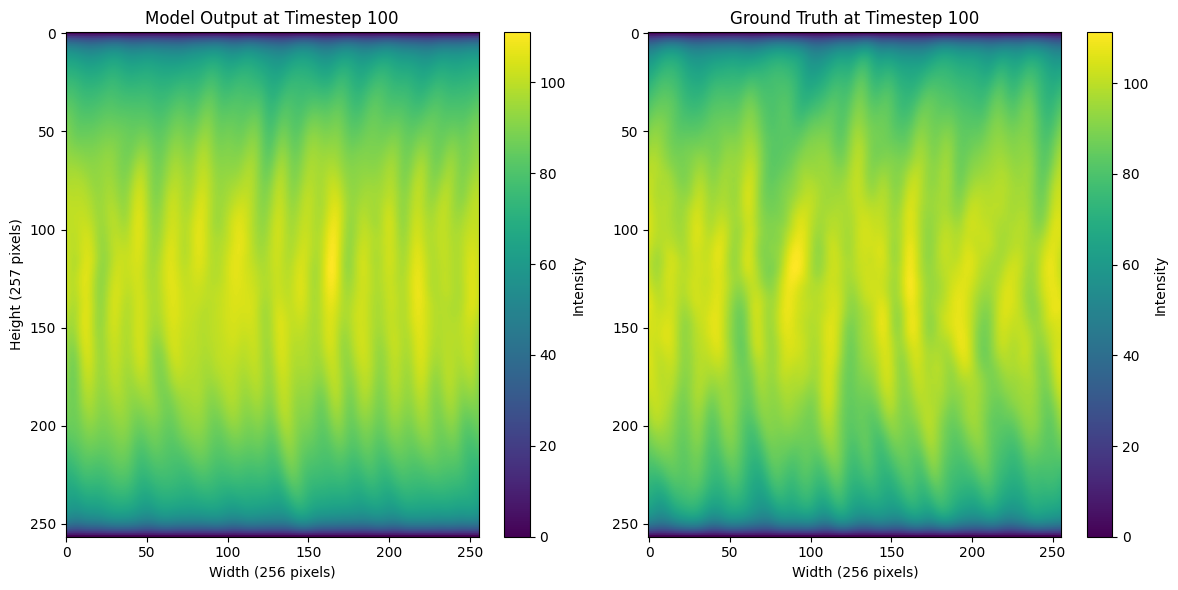

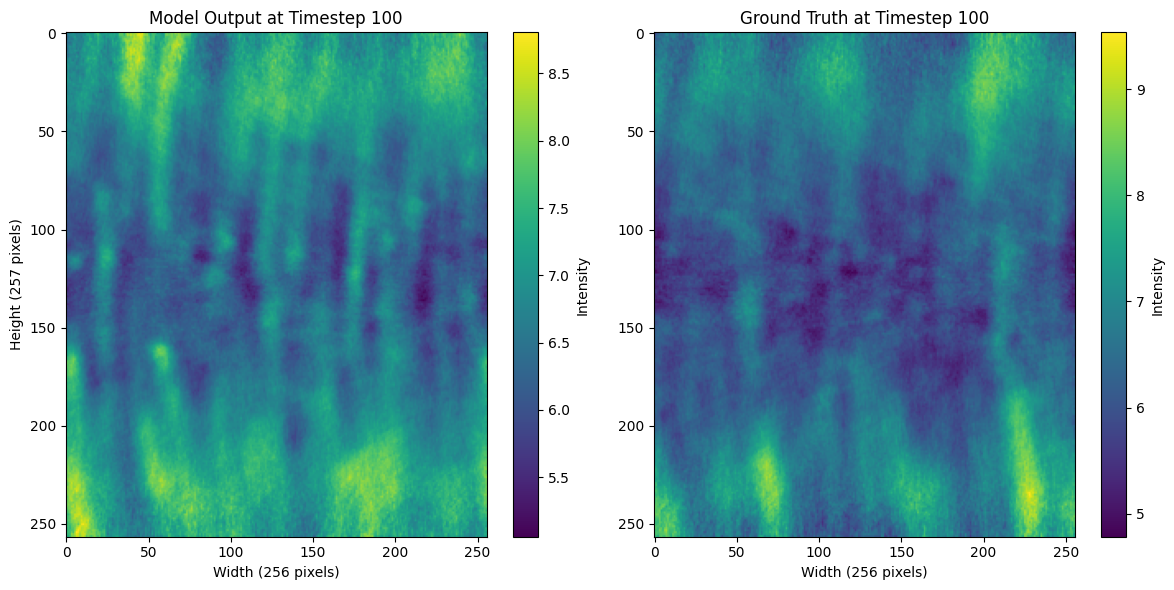

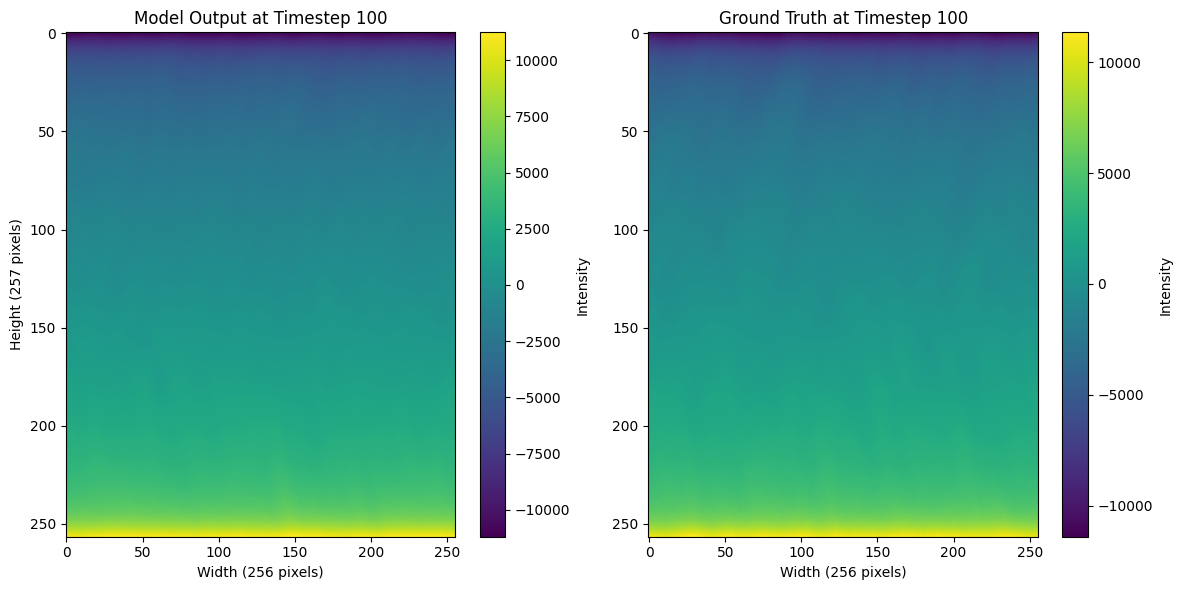

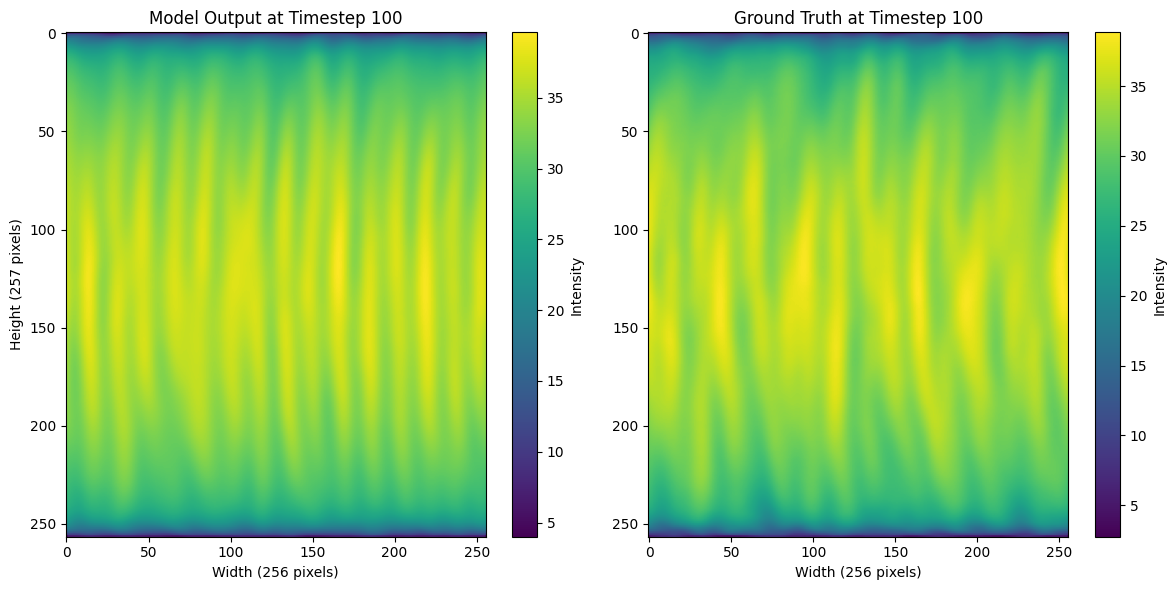

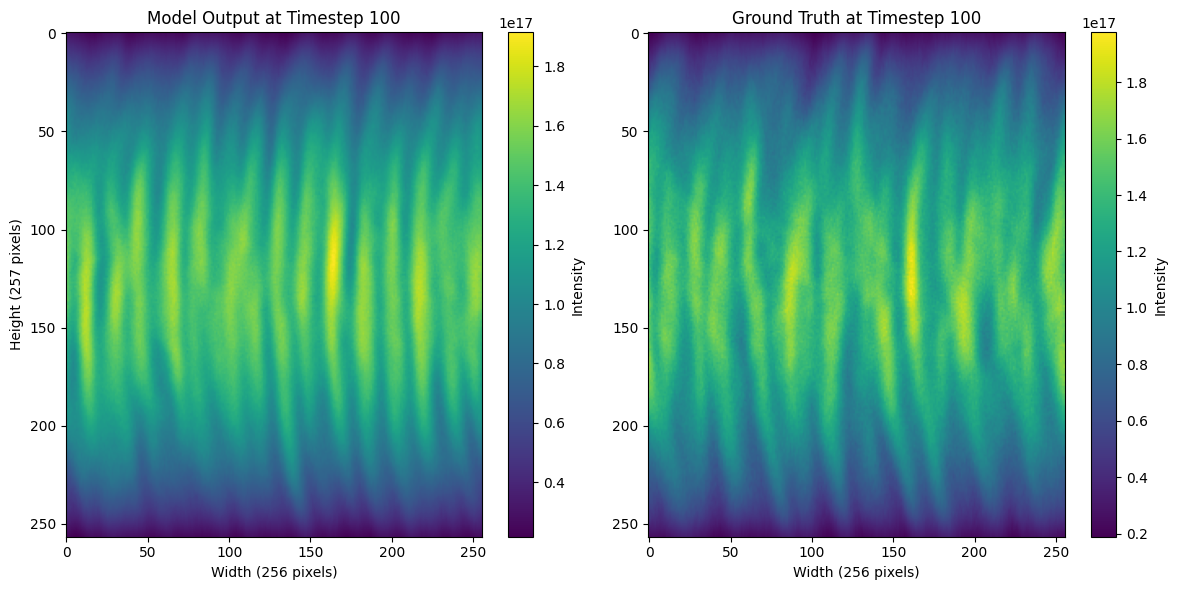

In [21]:
t = 100
for key in dataset_dict_prediction.keys():
    plot_frame_comparison(dataset_dict_prediction[key], true_dataset_dict_prediction[key], timestep=t)  # Plot frame at timestep 100

In [98]:
### Pure Forecast ###
sensor_measurements_for_prediction_dict = manager.generate_X(start = 2000, end = 2020, forecaster=shred.sensor_forecaster, method = 'predictor')
sensor_measurements_for_prediction = sensor_measurements_for_prediction_dict['X']
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

{0}   {3}
{0}   {3}
Generate_X: torch.Size([21, 21, 6])
Prediction: torch.Size([21, 197376])
Post-process (21, 257, 256)



In [99]:
manager.data_processors[0].sensor_measurements.shape

(2000, 3)

In [102]:
sensor_measurements_for_prediction_dict['sensor_measurements']

array([[0.        , 0.25303847, 0.        , 0.        , 0.25303847,
        0.        ],
       [0.00634941, 0.29624499, 0.00413059, 0.00634941, 0.29624499,
        0.00413059],
       [0.01271753, 0.30092845, 0.01350416, 0.01271753, 0.30092845,
        0.01350416],
       ...,
       [0.81017393, 0.80732423, 0.64945942, 0.81017393, 0.80732423,
        0.64945942],
       [0.83160287, 0.81175965, 0.64238656, 0.83160287, 0.81175965,
        0.64238656],
       [0.84522295, 0.8061617 , 0.64178294, 0.84522295, 0.8061617 ,
        0.64178294]])

In [81]:
### No Forecast, fill gaps with zeros ###
sensor_measurements_for_prediction = manager.generate_X(start = 2000, end = 2020, method = 'predictor')
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

AttributeError: 'dict' object has no attribute 'shape'

In [58]:
# Generate X only from data provided
sensor_measurements = manager.sensor_measurements.to_numpy()[:,1:]
print('sensor_measurements', sensor_measurements.shape)
sensor_measurements_generate_X = manager.generate_X(measurements=sensor_measurements, method = 'reconstructor')
print('generate_X',sensor_measurements_generate_X.shape)


sensor_measurements (2000, 6)
generate_X torch.Size([2000, 21, 6])


In [ ]:
# Generate X from data provided and historical data and sensor_forecaster, start_time, end_time 
sensor_measurements = manager.sensor_measurements.to_numpy()[:,1:]
print('sensor_measurements', sensor_measurements.shape)
sensor_measurements_generate_X = manager.generate_X(measurements=sensor_measurements, method = 'reconstructor')
print('generate_X',sensor_measurements_generate_X.shape)


In [46]:
sensor_measurements.shape

(2000, 6)

In [55]:
### No Forecast ###
sensor_measurements_for_prediction = manager.generate_X(start = 2000, end = 2099, measurements = sensor_measurements[0:100],
                                                        time = np.arange(2000,2100), forecaster=shred.sensor_forecaster,
                                                        method = 'predictor')
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

Generate_X: torch.Size([100, 21, 6])
Prediction: torch.Size([100, 197376])
Post-process (100, 257, 256)



In [56]:
test_set.sensor_forecaster_dataset.X

tensor([[[0.6870, 0.9409, 0.8707, 0.5560, 0.2721, 0.2404],
         [0.7948, 0.9429, 0.7940, 0.4380, 0.3155, 0.2174],
         [0.8882, 0.9428, 0.7176, 0.2787, 0.4195, 0.1737],
         ...,
         [0.6433, 0.4486, 0.7537, 0.5934, 0.6484, 0.2476],
         [0.6714, 0.4251, 0.8391, 0.4687, 0.5938, 0.2101],
         [0.6983, 0.4113, 0.9048, 0.3494, 0.5577, 0.1302]],

        [[0.7948, 0.9429, 0.7940, 0.4380, 0.3155, 0.2174],
         [0.8882, 0.9428, 0.7176, 0.2787, 0.4195, 0.1737],
         [0.9321, 0.9317, 0.6558, 0.2333, 0.5053, 0.1681],
         ...,
         [0.6714, 0.4251, 0.8391, 0.4687, 0.5938, 0.2101],
         [0.6983, 0.4113, 0.9048, 0.3494, 0.5577, 0.1302],
         [0.7213, 0.3987, 0.9251, 0.3191, 0.5231, 0.1617]],

        [[0.8882, 0.9428, 0.7176, 0.2787, 0.4195, 0.1737],
         [0.9321, 0.9317, 0.6558, 0.2333, 0.5053, 0.1681],
         [0.9288, 0.9193, 0.6183, 0.2643, 0.5800, 0.1868],
         ...,
         [0.6983, 0.4113, 0.9048, 0.3494, 0.5577, 0.1302],
         [

In [57]:
sensor_measurements_for_prediction

tensor([[[0.7590, 0.8064, 0.7529, 0.4170, 0.3547, 0.3551],
         [0.7096, 0.7672, 0.7435, 0.2435, 0.4557, 0.3386],
         [0.6666, 0.7048, 0.7149, 0.2460, 0.6052, 0.3178],
         ...,
         [0.5396, 0.5300, 0.6275, 0.5303, 0.5221, 0.2275],
         [0.5603, 0.5261, 0.6218, 0.5307, 0.5055, 0.2409],
         [0.0000, 0.2530, 0.0000, 0.1035, 0.6011, 1.0000]],

        [[0.7096, 0.7672, 0.7435, 0.2435, 0.4557, 0.3386],
         [0.6666, 0.7048, 0.7149, 0.2460, 0.6052, 0.3178],
         [0.6323, 0.6404, 0.6807, 0.3102, 0.7194, 0.3460],
         ...,
         [0.5603, 0.5261, 0.6218, 0.5307, 0.5055, 0.2409],
         [0.0000, 0.2530, 0.0000, 0.1035, 0.6011, 1.0000],
         [0.0063, 0.2962, 0.0041, 0.1180, 0.5568, 0.9605]],

        [[0.6666, 0.7048, 0.7149, 0.2460, 0.6052, 0.3178],
         [0.6323, 0.6404, 0.6807, 0.3102, 0.7194, 0.3460],
         [0.6227, 0.5941, 0.6534, 0.4162, 0.7271, 0.3433],
         ...,
         [0.0000, 0.2530, 0.0000, 0.1035, 0.6011, 1.0000],
         [

In [ ]:
### No Forecast ###
sensor_measurements_for_prediction = manager.generate_X(start = 2000, end = 2020, forecaster=shred.sensor_forecaster, method = 'predictor')
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, unscale = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

In [ ]:
# fake_new_measurements = manager.generate_X(measurements=all_sensor_measurements)

# print(test_set.forecaster.Y.shape)
# fake = test_set.forecaster.Y[0:5,:]
# print(fake.shape)

# time = np.arange(2020,2221)
# fake = test_set.sensor_forecaster_dataset.Y[0:len(time),:]

# sensor_measurements_for_prediction = manager.generate_X(start = 2006, end = 2020, measurements = fake, time = time, forecaster=shred._sensor_forecaster)